<a href="https://colab.research.google.com/github/Jade-Cartagena/QSAR-QSPR-Predictive-Models/blob/Predictive-Models/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  from rdkit import Chem
  from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
  from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import StratifiedKFold
  from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
  from sklearn.feature_selection import RFE
  import joblib
  from sklearn.metrics import (
      classification_report, accuracy_score, confusion_matrix,
      f1_score, roc_auc_score, precision_recall_curve, roc_curve
  )


[08:52:11] WARNING: not removing hydrogen atom without neighbors


Value counts for 'Antioxidant':
Antioxidant
False    2077
True     1981
Name: count, dtype: int64 

Value counts for 'Anti-inflammatory':
Anti-inflammatory
False    2094
True     1964
Name: count, dtype: int64 

Value counts for 'Toxic':
Toxic
False    2084
True     1974
Name: count, dtype: int64 


=== Antioxidant Prediction ===
Fitting estimator with 2060 features.
Fitting estimator with 2035 features.
Fitting estimator with 2010 features.
Fitting estimator with 1985 features.
Fitting estimator with 1960 features.
Fitting estimator with 1935 features.
Fitting estimator with 1910 features.
Fitting estimator with 1885 features.
Fitting estimator with 1860 features.
Fitting estimator with 1835 features.
Fitting estimator with 1810 features.
Fitting estimator with 1785 features.
Fitting estimator with 1760 features.
Fitting estimator with 1735 features.
Fitting estimator with 1710 features.
Fitting estimator with 1685 features.
Fitting estimator with 1660 features.
Fitting estimator with

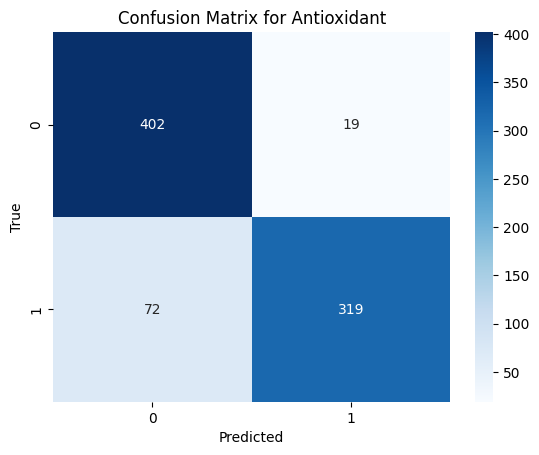

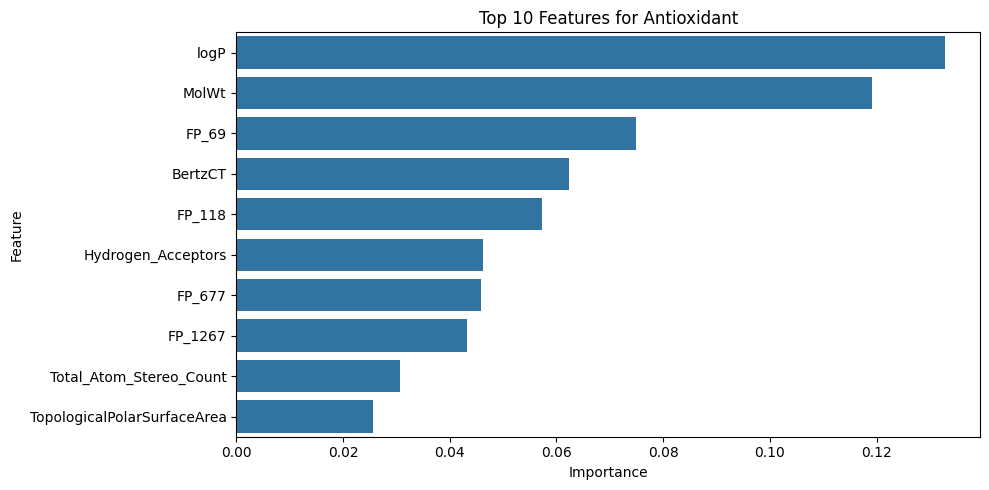

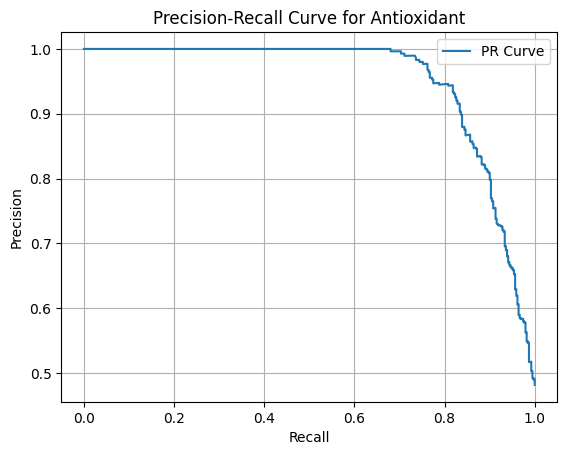

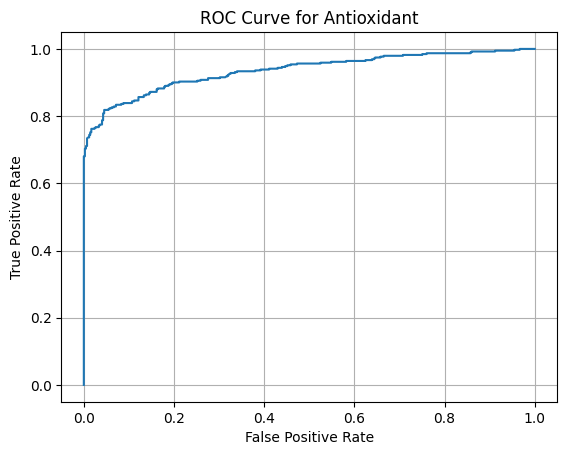


=== Anti-inflammatory Prediction ===
Fitting estimator with 2060 features.
Fitting estimator with 2035 features.
Fitting estimator with 2010 features.
Fitting estimator with 1985 features.
Fitting estimator with 1960 features.
Fitting estimator with 1935 features.
Fitting estimator with 1910 features.
Fitting estimator with 1885 features.
Fitting estimator with 1860 features.
Fitting estimator with 1835 features.
Fitting estimator with 1810 features.
Fitting estimator with 1785 features.
Fitting estimator with 1760 features.
Fitting estimator with 1735 features.
Fitting estimator with 1710 features.
Fitting estimator with 1685 features.
Fitting estimator with 1660 features.
Fitting estimator with 1635 features.
Fitting estimator with 1610 features.
Fitting estimator with 1585 features.
Fitting estimator with 1560 features.
Fitting estimator with 1535 features.
Fitting estimator with 1510 features.
Fitting estimator with 1485 features.
Fitting estimator with 1460 features.
Fitting esti

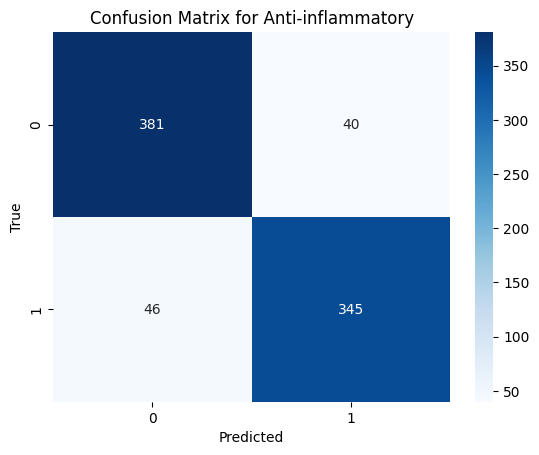

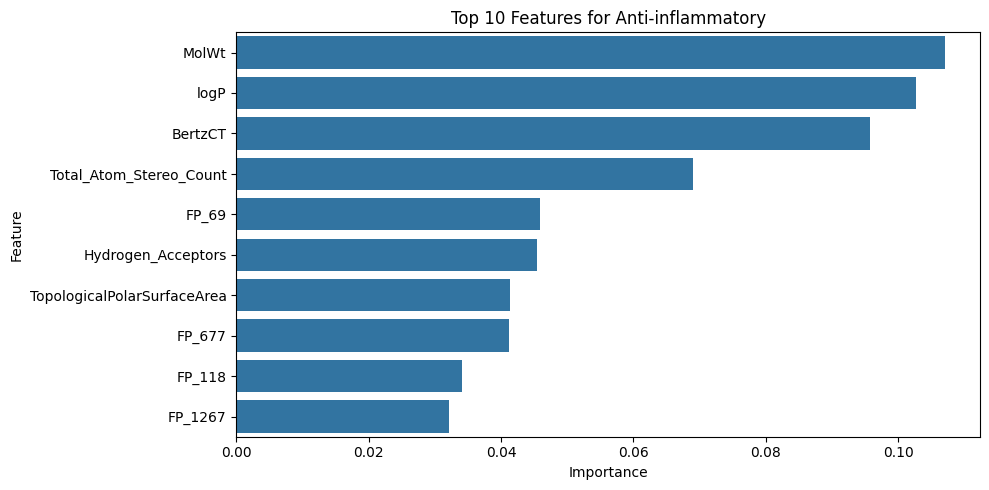

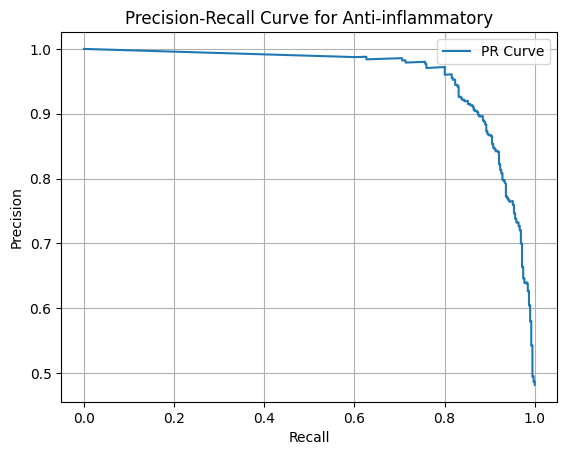

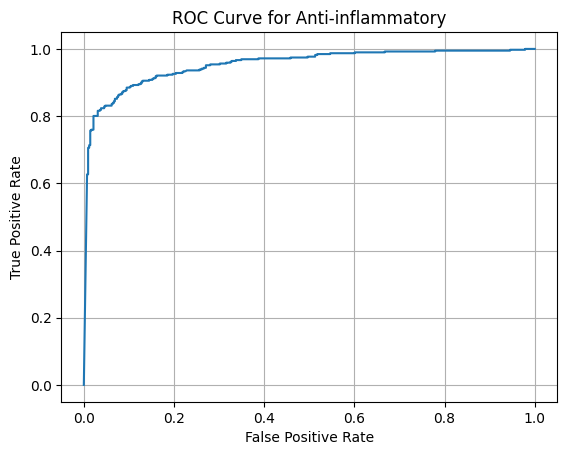


=== Toxic Prediction ===
Fitting estimator with 2060 features.
Fitting estimator with 2035 features.
Fitting estimator with 2010 features.
Fitting estimator with 1985 features.
Fitting estimator with 1960 features.
Fitting estimator with 1935 features.
Fitting estimator with 1910 features.
Fitting estimator with 1885 features.
Fitting estimator with 1860 features.
Fitting estimator with 1835 features.
Fitting estimator with 1810 features.
Fitting estimator with 1785 features.
Fitting estimator with 1760 features.
Fitting estimator with 1735 features.
Fitting estimator with 1710 features.
Fitting estimator with 1685 features.
Fitting estimator with 1660 features.
Fitting estimator with 1635 features.
Fitting estimator with 1610 features.
Fitting estimator with 1585 features.
Fitting estimator with 1560 features.
Fitting estimator with 1535 features.
Fitting estimator with 1510 features.
Fitting estimator with 1485 features.
Fitting estimator with 1460 features.
Fitting estimator with 1

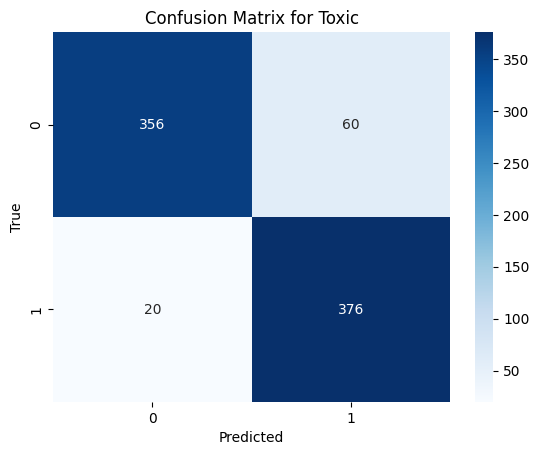

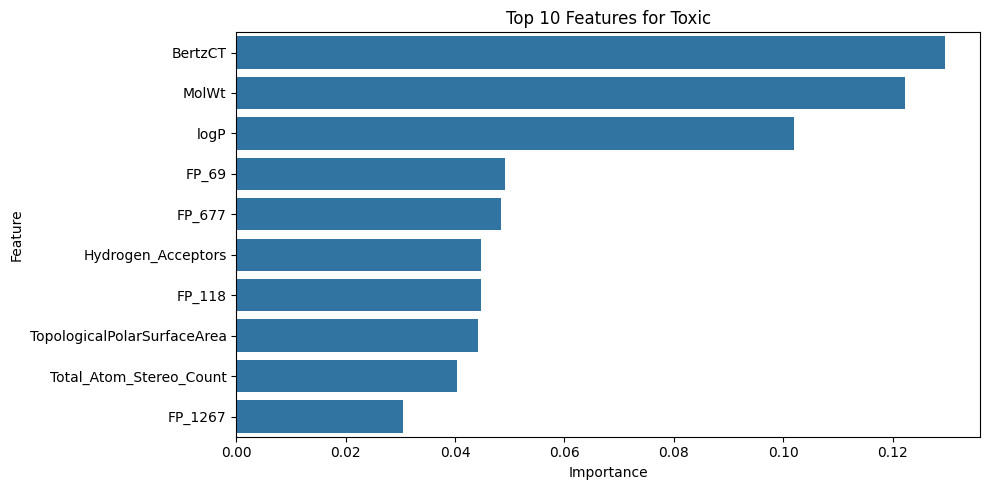

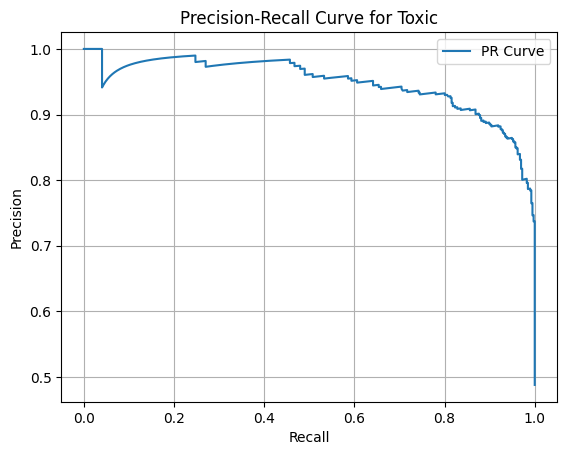

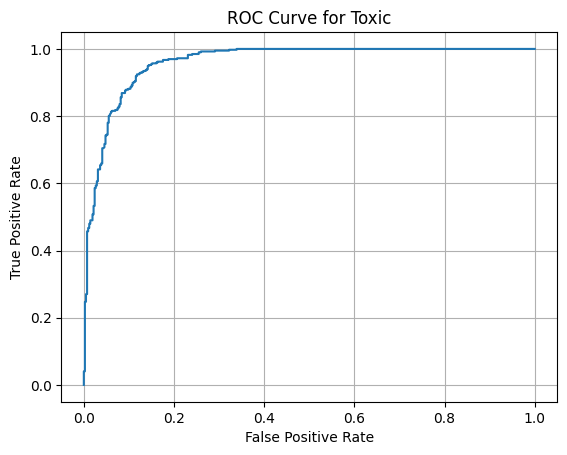

In [ ]:
  # Load dataset
  df = pd.read_csv("/content/QSAR-QSPR Finalized Dataset.csv")
  smiles_list = df["SMILES"].tolist()

  # Generate Morgan fingerprints
  generator = GetMorganGenerator(radius=2, fpSize=2048)
  fps = []
  for smi in smiles_list:
      mol = Chem.MolFromSmiles(smi)
      if mol:
          fp = generator.GetFingerprint(mol)
          arr = np.zeros((2048,), dtype=int)
          ConvertToNumpyArray(fp, arr)
          fps.append(arr)
      else:
          fps.append(np.zeros((2048,), dtype=int))

  fingerprint_df = pd.DataFrame(fps, columns=[f'FP_{i}' for i in range(2048)])

  # Drop SMILES
  df = df.drop(columns=["SMILES", "IUPAC_NAME", "NAME"])

  # Targets
  target_cols = ['Antioxidant', 'Anti-inflammatory', 'Toxic']
  for target in target_cols:
      print(f"Value counts for '{target}':")
      print(df[target].value_counts(), "\n")
  df[target_cols] = df[target_cols].astype(int)

  # Combine descriptors and fingerprints
  descriptor_features = df.drop(columns=target_cols).select_dtypes(include='number')
  features = pd.concat([descriptor_features, fingerprint_df], axis=1)

  # === Feature Selection: Remove Correlated Features ===
  corr_matrix = features.corr().abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
  features = features.drop(columns=to_drop)

  # Random Forest hyperparameter space
  param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [10, 20, 30, None],
      'min_samples_split': [2, 5, 10, 20],
      'min_samples_leaf': [1, 2, 4, 6],
      'max_features': ['sqrt', 'log2'],
      'bootstrap': [True, False],
      'class_weight': ['balanced']
  }

  # Prepare a DataFrame to log evaluation metrics for each target
  metrics_list = []

  # Modeling for each target
  for target in target_cols:
      print(f"\n=== {target} Prediction ===")

      y = df[target]
      X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

      # RFE for Feature Selection
      rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42),
                        n_features_to_select=100, step=25, verbose=1)
      X_train_selected = rfe_selector.fit_transform(X_train, y_train)
      X_test_selected = rfe_selector.transform(X_test)

      selected_features = features.columns[rfe_selector.get_support()]

      # Randomized Search
      model = RandomForestClassifier(random_state=42)
      cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
      model_random = RandomizedSearchCV(model, param_grid, n_iter=50, cv=4, n_jobs=-1, verbose=1)
      model_random.fit(X_train_selected, y_train)
      best_model = model_random.best_estimator_

      # === Save model and selector ===
      model_filename = f"{target.replace(' ', '_')}_RF_BestModel.joblib"
      rfe_filename = f"{target.replace(' ', '_')}_RFE_Selector.joblib"
      joblib.dump(best_model, model_filename)
      joblib.dump(rfe_selector, rfe_filename)
      print(f"✅ Saved model to {model_filename}")
      print(f"💾 Saved RFE selector to {rfe_filename}")

      # Cross-validation
      cv_scores = cross_val_score(best_model, X_train, y_train, cv=4)
      print("Cross-validated Accuracy:", cv_scores.mean())
      cv_roc_auc = cross_val_score(best_model, X_train, y_train, cv=4, scoring='roc_auc', n_jobs=-1)
      print("Cross-validated ROC AUC:", cv_roc_auc.mean())

      # Prediction & Probabilities
      y_prob = best_model.predict_proba(X_test_selected)[:, 1]

      # Optimal threshold using precision-recall curve
      precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
      f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
      best_threshold = thresholds[np.argmax(f1_scores)]
      y_pred_thresh = (y_prob > best_threshold).astype(int)

      # Metrics
      print("Optimal Threshold:", round(best_threshold, 3))
      print("Accuracy:", accuracy_score(y_test, y_pred_thresh))
      print("F1 Score (Macro):", f1_score(y_test, y_pred_thresh, average='macro'))
      print("F1 Score (Weighted):", f1_score(y_test, y_pred_thresh, average='weighted'))
      print("ROC AUC:", roc_auc_score(y_test, y_prob))
      print("Classification Report:")
      print(classification_report(y_test, y_pred_thresh))

      # Confusion Matrix
      cm = confusion_matrix(y_test, y_pred_thresh)
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
      plt.title(f"Confusion Matrix for {target}")
      plt.xlabel("Predicted")
      plt.ylabel("True")
      plt.show()

      # Feature Importance
      importances = best_model.feature_importances_
      feat_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
      feat_df = feat_df.sort_values(by='Importance', ascending=False)

      plt.figure(figsize=(10, 5))
      sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
      plt.title(f"Top 10 Features for {target}")
      plt.tight_layout()
      plt.show()

      # PR Curve
      precisions, recalls, _ = precision_recall_curve(y_test, y_prob)
      plt.plot(recalls, precisions, label="PR Curve")
      plt.xlabel("Recall")
      plt.ylabel("Precision")
      plt.title(f"Precision-Recall Curve for {target}")
      plt.legend()
      plt.grid()
      plt.show()

      # ROC Curve
      fpr, tpr, _ = roc_curve(y_test, y_prob)
      plt.plot(fpr, tpr)
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.title(f"ROC Curve for {target}")
      plt.grid(True)
      plt.show()